For this first deliverable, I need to develop this:
<br /> 1.- Apply scaling techniques
<br /> 2.- preprocess of data

In [ ]:
# All the imports come here
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [13]:
# It's important to comment the import depending on the OS
# Windows PC
base_dir = r"./dataset/car parts"

# Mac OS
# base_dir = "/Users/alanpagzz/Codes/carssification_AI/dataset/car parts"

# Google Colab
# from google.colab import drive
# drive.mount('/content/drive')
# drive_dataset_path = "/content/drive/MyDrive/Octavo Semestre/IA/proyecto/car dataset/car parts"

# New local route
# local_dataset_path = "/content/car_parts"

# Copy the dataset to the local machine (just once)
# if not os.path.exists(local_dataset_path):
#     shutil.copytree(drive_dataset_path, local_dataset_path)

In [14]:
train_dir = os.path.join(base_dir , "train")
valid_dir = os.path.join(base_dir , "valid")

# I will omit the test directory for now. I don't want to mix the test data with the training data

In [15]:
# Time to preprocess the data

# SCALING
# First, scale pixels. Refer te README for the preprocess_input value
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range = 10,
    width_shift_range = 0.2,
	  height_shift_range = 0.2,
    #shear_range = 0.3,
	  #zoom_range = 0.3,
	  horizontal_flip = True
    )

valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range = 10,
    width_shift_range = 0.2,
	  height_shift_range = 0.2,
    #shear_range = 0.3,
	  #zoom_range = 0.3,
	  horizontal_flip = True
        )


# PREPROCESS
train_generator = train_datagen.flow_from_directory(
    train_dir,
    # My images are 254x254
    target_size=(254, 254),
    batch_size=8,
    class_mode="categorical",
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(254, 254),
    batch_size=8,
    class_mode="categorical",
    shuffle=False
)


Found 6917 images belonging to 40 classes.
Found 200 images belonging to 40 classes.


In [16]:
# ResNet50
# Retrieved from documentation

with tf.device('/GPU:0'):
      ResNet50 = tf.keras.applications.ResNet50(
        input_shape=(254, 254, 3),
        include_top=False,
        weights="imagenet",
        classifier_activation="softmax",
        name="resnet50"
      )

      ResNet50.trainable = False

  # This is my model
      model = tf.keras.models.Sequential([
        ResNet50,
        GlobalAveragePooling2D(),
        Dense(512, activation = 'relu'),
        Dense(128, activation = 'relu'),
        Dense(40, activation = 'softmax')
  ])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 40)             │         5,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,707,624 (94.25 MB)

 Trainable params: 1,119,912 (4.27 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Time to add a checkpoint

# I want it on the same spot on every device, It's easier

# Drive
# checkpoint_path = "/content/drive/MyDrive/Octavo Semestre/IA/proyecto/checkpoints/cp-{epoch:02d}.keras"

# Windows
# checkpoint_path = os.path.join(r"./", "checkpoints", "cp-{epoch:02d}.keras")

# Mac OS
# checkpoint_path = PUTSOMETHINGHERE

# Callback to save the best model
checkpoint_cb = ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

# Callback to stop if tehre's no improvement in 3 epochs
earlystop_cb = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
def compile_model_simple(newModel):
    # CATEGORICAL CROSS SENTROPY
    newModel.compile(optimizer= "adam", loss = "categorical_crossentropy", metrics=['accuracy'])

def train_model_simple(newModel, scaled_train_images):
  # The cancer model paper mentions that it reaches a good level of accuracy on
  # epoch 20ish (The graph is up to epoch 25)
    history = newModel.fit(scaled_train_images,
                        validation_data=valid_generator,
                        epochs = 25,
                        callbacks=[checkpoint_cb, earlystop_cb])
    return history

In [19]:
compile_model_simple(model)
history = train_model_simple(model, train_generator)

C:\Users\patom\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
865/865 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5679 - loss: 1.6162
Epoch 1: val_accuracy improved from -inf to 0.79000, saving model to ./checkpoints\cp-01.keras
865/865 ━━━━━━━━━━━━━━━━━━━━ 1429s 2s/step - accuracy: 0.5680 - loss: 1.6155 - val_accuracy: 0.7900 - val_loss: 0.7136
Epoch 2/5
865/865 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8461 - loss: 0.4795
Epoch 2: val_accuracy improved from 0.79000 to 0.85000, saving model to ./checkpoints\cp-02.keras
865/865 ━━━━━━━━━━━━━━━━━━━━ 1342s 2s/step - accuracy: 0.8461 - loss: 0.4795 - val_accuracy: 0.8500 - val_loss: 0.5839
Epoch 3/5
865/865 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8930 - loss: 0.3249
Epoch 3: val_accuracy did not improve from 0.85000
865/865 ━━━━━━━━━━━━━━━━━━━━ 1225s 1s/step - accuracy: 0.8930 - loss: 0.3249 - val_accuracy: 0.8100 - val_loss: 0.8288
Epoch 4/5
865/865 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9122 - loss: 0.2764
Epoch 4: val_accuracy improved from 0.85000 to 0.88500, saving 

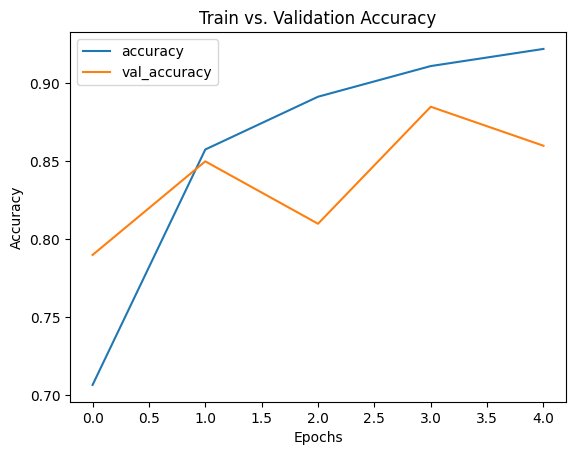

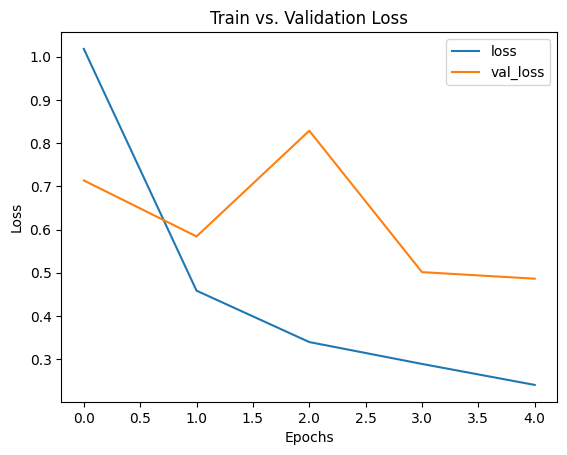

In [20]:
frame = pd.DataFrame(history.history)
acc_plot = frame.plot(y=["accuracy", "val_accuracy"], title="Train vs. Validation Accuracy", legend=True)
acc_plot.set(xlabel="Epochs", ylabel="Accuracy")
plt.show()

loss_plot = frame.plot(y=["loss", "val_loss"], title="Train vs. Validation Loss", legend=True)
loss_plot.set(xlabel="Epochs", ylabel="Loss")
plt.show()

In [22]:
# Getting results
true_classes = valid_generator.classes
valid_generator.reset()

# Get model predictions on validation data
val_pred_probs = model.predict(valid_generator, verbose=1)

# Get predicted classes
val_pred_classes = np.argmax(val_pred_probs, axis=1)

# Get true classes from generator
num_classes = len(valid_generator.class_indices)

conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

for i in range(len(true_classes)):
    actual = true_classes[i]
    pred = val_pred_classes[i]
    conf_matrix[actual][pred] += 1


25/25 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step


In [24]:
precisions = []
recalls = []
f1s = []

for i in range(num_classes):
    TP = conf_matrix[i][i]
    FP = np.sum(conf_matrix[:, i]) - TP
    FN = np.sum(conf_matrix[i, :]) - TP
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

# Averages
macro_precision = np.mean(precisions)
macro_recall = np.mean(recalls)
macro_f1 = np.mean(f1s)

print(f"precision: {macro_precision:.4f}, recall: {macro_recall:.4f}, f1: {macro_f1:.4f}")

precision: 0.8977, recall: 0.8650, f1: 0.8645


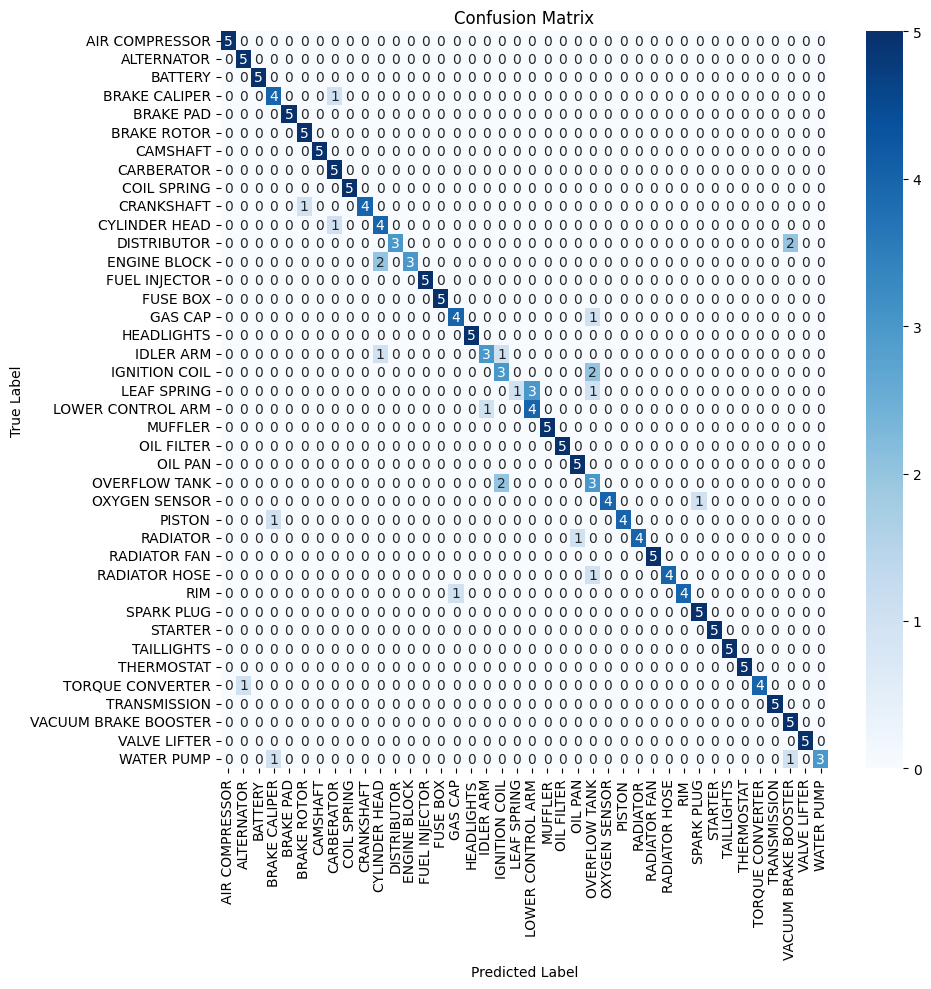

In [31]:
# printing the confusion matrix
class_names = list(valid_generator.class_indices.keys())
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [1]:
# Load the saved model
checkpoint_path = r"./checkpoints/cp-06.keras"

model = tf.keras.models.load_model(checkpoint_path)
if model is not None:
    print("Model loaded successfully.")
else:
    print("Failed to load the model.")

# Now, I need to add a route for the input image
image_path = r"./wednesdayTest/images.jpeg"  # Replace with your image path
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(254, 254))
image = tf.keras.preprocessing.image.img_to_array(image)
image = np.expand_dims(image, axis=0)
image = preprocess_input(image)  # Apply the same preprocessing as training

# Make predictions
predictions = model.predict(image)
predicted_class = np.argmax(predictions, axis=1)[0]


# Evaluar el modelo en el conjunto de validación

# Print the predicted class
print(f"Predicted class: {class_names[predicted_class]}")

NameError: name 'tf' is not defined